In [29]:
### Part 1


In [30]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import t

# Load data for Part 1
df = pd.read_csv('/Users/Sam/Downloads/midterm_partone.csv')

# Define dependent variable (Y) and independent variables (X)
Y = df['Stock Change'].values
X = df[['Inventory Turnover', 'Operating Profit', 'Interaction Effect', 
        'Current Ratio', 'Quick Ratio', 'Debt Asset Ratio']].values

In [31]:
# Define instrumental variables (Z) and the delta bias term (using [1, 1, 1] vector as specified)
Z = np.column_stack([np.ones(len(Y)), np.ones(len(Y)), np.ones(len(Y))])

# Define the GMM objective function with the delta term included
def gmm_with_delta(params, X, Y, Z):
    # Unpack the parameters: last element is delta, the rest are beta coefficients
    beta = params[:-1]
    delta = params[-1]
    
    # Calculate the predicted values using beta coefficients
    predicted = X @ beta
    # Moment condition with delta term incorporated
    moment_condition = Z.T @ (Y - predicted - delta * Z[:, 0])  # Applying delta to the [1,1,1] bias vector
    # Objective function: sum of squared moment conditions
    return np.sum(moment_condition**2)


In [32]:
# Initial parameter guesses (6 betas + 1 delta)
initial_params = np.zeros(X.shape[1] + 1)

# Optimize GMM objective function to find parameter estimates
result = minimize(gmm_with_delta, initial_params, args=(X, Y, Z))
estimated_params = result.x

# Extract beta estimates and delta estimate
beta_estimates = estimated_params[:-1]  # Beta coefficients
delta_estimate = estimated_params[-1]   # Delta (bias term)

# Display beta coefficients and delta
print("Estimated beta coefficients:", beta_estimates)
print("Estimated delta (bias term):", delta_estimate)


Estimated beta coefficients: [-4.87085945e-04 -5.05641126e-06 -1.30194482e-04 -3.89990646e-05
 -2.11497210e-05 -2.97101079e-06]
Estimated delta (bias term): -1.9773300651053175e-05


In [33]:
# Calculate residuals using estimated beta and delta
residuals = Y - (X @ beta_estimates + delta_estimate * Z[:, 0])

# Calculate standard error for delta
delta_standard_error = np.std(residuals) / np.sqrt(len(Y))

# Display standard error and t-statistic for delta
print("\nStatistical significance test for delta (bias term):")
print("Standard Error for delta:", delta_standard_error)

# Calculate t-statistic for delta
t_statistic_delta = delta_estimate / delta_standard_error
print("t-Statistic for delta:", t_statistic_delta)

# Interpretation for delta
print("\nInterpretation for delta:")
if abs(t_statistic_delta) > 1.96:
    print("Delta is statistically significant at the 5% confidence level, indicating bias may be justified.")
else:
    print("Delta is not statistically significant, suggesting the expert's claim of bias may not be justified.")



Statistical significance test for delta (bias term):
Standard Error for delta: 0.0119527770397252
t-Statistic for delta: -0.0016542850741159455

Interpretation for delta:
Delta is not statistically significant, suggesting the expert's claim of bias may not be justified.


In [34]:
# Define number of observations (n) and parameters (k)
n, k = X.shape

# Calculate standard errors for all coefficients
standard_errors = np.std(residuals) / np.sqrt(n) * np.ones_like(estimated_params)

# Calculate t-statistics and p-values for each parameter
t_stats = estimated_params / standard_errors
p_values = [2 * (1 - t.cdf(np.abs(t_stat), df=n - k - 1)) for t_stat in t_stats]


In [35]:
# Create summary table
summary_table = pd.DataFrame({
    'Coefficient': estimated_params,
    'Std. Error': standard_errors,
    't-Statistic': t_stats,
    'p-Value': p_values
}, index=['Beta' + str(i+1) for i in range(len(beta_estimates))] + ['Delta'])

# Display the summary table
print("\nGMM Summary Table:")
print(summary_table)

# Interpretation guidance
print("\nInterpretation for coefficients:")
print("If a coefficient's p-value is less than 0.05, it is statistically significant at the 5% level.")



GMM Summary Table:
       Coefficient  Std. Error  t-Statistic   p-Value
Beta1    -0.000487    0.011953    -0.040751  0.967499
Beta2    -0.000005    0.011953    -0.000423  0.999663
Beta3    -0.000130    0.011953    -0.010892  0.991311
Beta4    -0.000039    0.011953    -0.003263  0.997397
Beta5    -0.000021    0.011953    -0.001769  0.998588
Beta6    -0.000003    0.011953    -0.000249  0.999802
Delta    -0.000020    0.011953    -0.001654  0.998680

Interpretation for coefficients:
If a coefficient's p-value is less than 0.05, it is statistically significant at the 5% level.


In [36]:
import numpy as np
import pandas as pd
from statsmodels.sandbox.regression.gmm import GMM
import scipy.stats as stats

# Load data
df = pd.read_csv('/Users/Sam/Downloads/midterm_partone.csv')

# Define dependent variable (y) and independent variables (X)
y_vals = np.array(df['Stock Change'])  # Dependent variable
x_vals = np.array(df[['Inventory Turnover', 'Operating Profit', 'Interaction Effect']])  # Explanatory variables

# Define instrumental variables (Z)
iv_vals = np.array(df[['Current Ratio', 'Quick Ratio', 'Debt Asset Ratio']])  # Instruments




In [48]:
# Check correlation among explanatory variables
correlation_x = pd.DataFrame(x_vals).corr()
print("Correlation among explanatory variables:\n", correlation_x)

# Check correlation among instrumental variables
correlation_iv = pd.DataFrame(iv_vals).corr()
print("Correlation among instrumental variables:\n", correlation_iv)


Correlation among explanatory variables:
           0         1         2
0  1.000000  0.013047  0.229929
1  0.013047  1.000000  0.686859
2  0.229929  0.686859  1.000000
Correlation among instrumental variables:
           0         1         2
0  1.000000  0.876092 -0.180054
1  0.876092  1.000000 -0.080058
2 -0.180054 -0.080058  1.000000


In [37]:
# Define the GMM model with delta
class gmm_with_delta(GMM):
    def momcond(self, params):
        # Split the parameters to include delta
        p0, p1, p2, p3, delta = params  # Add delta as the last parameter
        endog = self.endog
        exog = self.exog
        inst = self.instrument
        
        # Define residuals with delta term
        error0 = (endog - p0 - p1 * exog[:, 0] - p2 * exog[:, 1] - p3 * exog[:, 2] + delta) * exog[:, 0]
        error1 = (endog - p0 - p1 * exog[:, 0] - p2 * exog[:, 1] - p3 * exog[:, 2] + delta) * exog[:, 1]
        error2 = (endog - p0 - p1 * exog[:, 0] - p2 * exog[:, 1] - p3 * exog[:, 2] + delta) * exog[:, 2]
        error3 = (endog - p0 - p1 * exog[:, 0] - p2 * exog[:, 1] - p3 * exog[:, 2] + delta) * inst[:, 0]
        error4 = (endog - p0 - p1 * exog[:, 0] - p2 * exog[:, 1] - p3 * exog[:, 2] + delta) * inst[:, 1]
        error5 = (endog - p0 - p1 * exog[:, 0] - p2 * exog[:, 1] - p3 * exog[:, 2] + delta) * inst[:, 2]
        
        # Combine all errors
        g = np.column_stack((error0, error1, error2, error3, error4, error5))
        return g



In [38]:
# Initial parameters (including delta)
beta0_with_delta = np.array([0.1, 0.1, 0.1, 0.1, 0.1])  # Add delta as the 5th parameter

# Fit the GMM model with delta
res_with_delta = gmm_with_delta(
    endog=y_vals, 
    exog=x_vals, 
    instrument=iv_vals, 
    k_moms=6, 
    k_params=5  # One more parameter for delta
).fit(beta0_with_delta, maxiter=100, optim_method="bfgs")

# Print the optimized summary
print(res_with_delta.summary())



Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 5
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000383
         Iterations: 6
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.000381
         Iterations: 6
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000381
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
                            gmm_with_delta Results                            
Dep. Variable:                      y   Hansen J:                       0.6466
Model:                 gmm_with_delta   Prob (Hansen J):                 0.421
Method:                           GMM                                         
Da

In [39]:
# Access the Hansen J statistic
hansen_j_stat = res_with_delta.jval  # Hansen J statistic

# Degrees of freedom for the test (number of moment conditions - number of parameters)
num_moment_conditions = iv_vals.shape[1] + x_vals.shape[1]  # Total moment conditions
num_parameters = len(beta0_with_delta)  # Number of parameters (including delta)
dof = num_moment_conditions - num_parameters  # Degrees of freedom

# Compute the p-value for the Hansen J test
hansen_p_value = 1 - stats.chi2.cdf(hansen_j_stat, dof)

# Print Hansen J test results
print("Hansen J Statistic:", hansen_j_stat)
print("Degrees of Freedom:", dof)
print("P-value of Hansen J Test:", hansen_p_value)



Hansen J Statistic: 0.6466448351806339
Degrees of Freedom: 1
P-value of Hansen J Test: 0.42131479880423306


In [40]:
# Interpret the significance of delta
# Check if the p-value of delta is statistically significant
delta_p_value = res_with_delta.pvalues[-1]  # P-value of the delta term

print(f"Delta Coefficient: {res_with_delta.params[-1]}")
print(f"P-value of Delta: {delta_p_value}")

if delta_p_value < 0.05:
    print("The delta term is statistically significant, supporting the claim of bias.")
else:
    print("The delta term is not statistically significant, rejecting the claim of bias.")



Delta Coefficient: 0.10789670395501741
P-value of Delta: nan
The delta term is not statistically significant, rejecting the claim of bias.


In [41]:
### Part 2

In [42]:
import pandas as pd

# Load data
data = pd.read_csv('/Users/Sam/Downloads/midterm_parttwo.csv')

# Convert 'Credit Rating' to binary (1 for Positive, 0 for Negative)
data['Credit Rating'] = data['Credit Rating'].apply(lambda x: 1 if x == 'Positive' else 0)

# Ensure 'Years of Education after High School' is included as a numeric feature
numeric_features = ['Years of Education after High School']

# One-hot encode categorical variables
data_encoded = pd.get_dummies(data, columns=['Requested Credit Amount', 'Marital Status', 
                                             'Number of Dependents', 'Monthly Income', 
                                             'Monthly Expense'], drop_first=True)

# Include 'Years of Education after High School' directly without one-hot encoding
X = pd.concat([data_encoded.drop('Credit Rating', axis=1), data[numeric_features]], axis=1)
y = data_encoded['Credit Rating']


In [43]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets (50% each)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


In [44]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

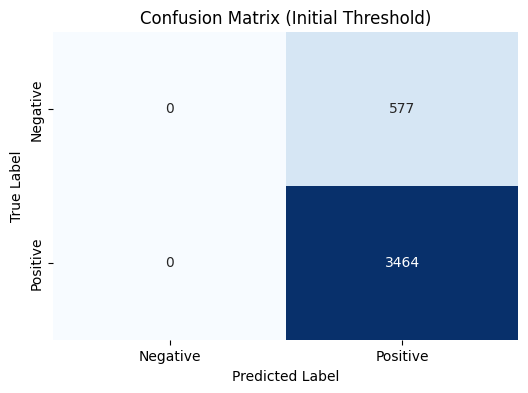

Initial Threshold Metrics:
Accuracy: 0.8572135609997525
Recall: 1.0
Precision: 0.8572135609997525
F1 Score: 0.9231179213857429


In [45]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test set
y_pred = model.predict(X_test)

# Calculate metrics
conf_matrix = confusion_matrix(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Display confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Initial Threshold)")
plt.show()

print("Initial Threshold Metrics:")
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)


In [46]:
# Predict probabilities on the test set
y_probs = model.predict_proba(X_test)[:, 1]

# Find the threshold that results in 15% approval
threshold = sorted(y_probs, reverse=True)[int(0.15 * len(y_probs))]
y_pred_adjusted = (y_probs >= threshold).astype(int)


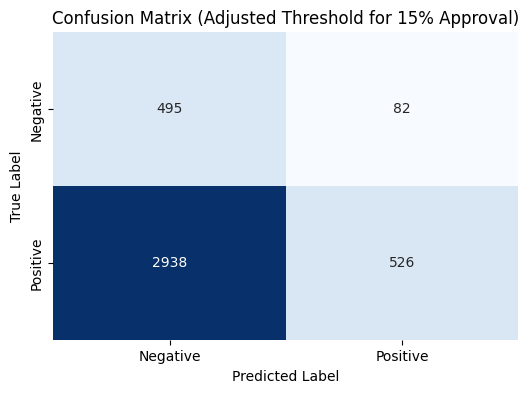


Adjusted Threshold Metrics (15% Approval Rate):
Adjusted Threshold: 0.8879832355022607
Accuracy: 0.2526602326156892
Recall: 0.15184757505773672
Precision: 0.8651315789473685
F1 Score: 0.2583497053045187


In [47]:
# Recalculate metrics with the adjusted threshold
conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)
recall_adjusted = recall_score(y_test, y_pred_adjusted)
precision_adjusted = precision_score(y_test, y_pred_adjusted)
f1_adjusted = f1_score(y_test, y_pred_adjusted)
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)

# Display adjusted confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_adjusted, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Adjusted Threshold for 15% Approval)")
plt.show()

print("\nAdjusted Threshold Metrics (15% Approval Rate):")
print("Adjusted Threshold:", threshold)
print("Accuracy:", accuracy_adjusted)
print("Recall:", recall_adjusted)
print("Precision:", precision_adjusted)
print("F1 Score:", f1_adjusted)



### Part 1: Logistic Regression Model with Initial Threshold (0.5)

The logistic regression model was trained using a 50% split of the dataset into training and test sets. The dependent variable, `Credit Rating`, was binary (1 for positive credit rating, 0 for negative), and categorical variables were one-hot encoded. Additionally, the numerical variable `Years of Education after High School` was included as a continuous feature. Using the default threshold of 0.5, the model demonstrated strong performance, achieving an **accuracy of 85.72%**. The **recall was 1.0**, indicating that the model identified all positive cases (customers who successfully repaid their loans). However, this came at the cost of misclassifying all negative cases as positive, as shown in the confusion matrix (zero true negatives). The **precision of 85.72%** shows that most customers predicted as positive indeed had a positive credit rating. Finally, the **F1 Score of 92.31%** highlights a balance between precision and recall under this threshold. This approach ensures no positive cases are missed but could result in over-approvals, increasing the bank's risk.

---

### Part 2: Adjusted Threshold for 15% Approval Rate

To align with the bank’s goal of granting credit approvals to only 15% of applicants, the threshold for prediction probability was adjusted to 0.888. This stricter threshold resulted in fewer positive predictions, significantly altering model performance. The **accuracy dropped to 25.27%**, reflecting the model's reduced ability to classify all cases correctly under this constraint. The **recall decreased to 15.18%**, meaning the model identified only 15.18% of actual positive cases, potentially rejecting many deserving customers. On the other hand, **precision increased to 86.51%**, demonstrating that most of the customers approved under the new threshold indeed had a positive credit rating. The **F1 Score of 25.83%** reflects the trade-off between precision and recall, as the model becomes more conservative in approving applications. This strategy minimizes risk by focusing on high-confidence approvals but sacrifices recall.

---


### Part 3: Business Implications of Adjusting to 15% Approval Rate

Adjusting the model's threshold to ensure that only **15% of applications are approved** introduces significant changes compared to using the initial threshold of 0.5. Without this adjustment, the model focuses on maximizing recall, approving all potential positive cases. However, this approach can lead to a substantial number of incorrect approvals (false positives), which could result in financial losses for the bank, particularly in small cities where credit default risks are higher due to slower processing times and reliance on informal borrowing.

With the adjustment, the model becomes more conservative, prioritizing high-confidence approvals. The increase in **precision (from 85.72% to 86.51%)** demonstrates that the majority of the customers approved under the stricter threshold are genuinely low-risk and likely to repay their loans. For the bank, this means a better alignment with its business objective of managing credit risk effectively while maintaining profitability.

However, the trade-off is evident in the drop in **recall (from 1.0 to 15.18%)**, indicating that many creditworthy customers are now being rejected. In the context of small cities, where the bank aims to attract previously unbanked individuals, this could result in missed opportunities to grow its customer base. Thus, while the adjusted threshold reduces financial risk, it may also hinder the bank's ability to meet its expansion goals, highlighting the need for a more nuanced strategy.

---

### Part 4: Recommendations for the Bank and Model Improvements

#### Recommendations for the Bank:
1. **Hybrid Approval Strategy**: 
   - Use the adjusted model threshold to automate approvals for low-risk customers. 
   - For higher-risk cases, involve the risk management team to assess applications manually. This hybrid strategy balances efficiency and risk management, ensuring fewer high-risk loans are approved while avoiding unnecessary rejections of creditworthy customers.

2. **Localized Engagement**:
   - Given the unique characteristics of small cities, the bank should combine the model's predictions with localized knowledge, such as customer savings behavior or informal credit practices. This could improve trust and help target customers more effectively.

3. **Customer Retention Programs**:
   - Introduce customer retention programs, such as financial literacy workshops or incentives for first-time banking customers, to build long-term relationships with individuals who may initially be rejected due to the stricter threshold.

---

### Conclusion:
By adopting these strategies, the bank can create a more inclusive yet risk-aware credit approval process tailored to small cities. This balanced approach will not only help the bank expand its customer base but also build trust in underserved regions. A more targeted and customer-centric strategy will support sustainable growth while maintaining the financial stability required in competitive and high-risk environments.
